# Tackling the Kaggle Melanoma Classification Competition
> Combining tabular and vision data to classify Melanoma  

- toc:true
- branch: master
- badges: true
- comments: true
- author: Mohamed Arshath
- categories: [image classification, fastai.medical]

In this blog, we will loosely follow the [winning solution](https://github.com/haqishen/SIIM-ISIC-Melanoma-Classification-1st-Place-Solution) to tackle the Melanoma Classification [Kaggle competition](https://github.com/haqishen/SIIM-ISIC-Melanoma-Classification-1st-Place-Solution). The solution combines an output from a CNN model with output from tabular model before the final output. The method is summarised in the picture below.  

![image.png](attachment:image.png)
Source: https://github.com/haqishen/SIIM-ISIC-Melanoma-Classification-1st-Place-Solution

What will we be doing here:

1. We will build a dataloader to combine vision data and tabular data. We will make use of [Zach Mueller's](https://twitter.com/TheZachMueller) MixedDL. Discussion on MixedDL can be found [here](https://forums.fast.ai/t/combining-tabular-images-in-fastai2-and-should-work-with-almost-any-other-type/73197/13).
2. We will also use albumentation library for our transforms as was used in the winning solution. 
3. We will build a model that classfies melanoma or no melanoma using both the image data and the tabular data. For image, we will use timm's `seresnext50_32x4d` and for the tabular data, we will make use of fastai's `TabularModel`. This is different from the winning solution. 



Resources/references:

https://www.kaggle.com/muellerzr/fastai2-tabular-vision-starter-kernel

https://forums.fast.ai/t/combining-tabular-images-in-fastai2-and-should-work-with-almost-any-other-type/73197/13

https://walkwithfastai.com/Multimodal_Head_and_Kaggle

https://github.com/haqishen/SIIM-ISIC-Melanoma-Classification-1st-Place-Solution

https://www.kaggle.com/c/siim-isic-melanoma-classification

# Imports and basic EDA

In [ ]:
#hide
!pip install timm -q

In [ ]:
#collapse-hide
from fastai.vision.all import *
from fastai.tabular.all import *
from fastai.medical.imaging import *

from fastai.data.load import _FakeLoader, _loaders
from timm import create_model

import pydicom
from pydicom.pixel_data_handlers.util import convert_color_space

import albumentations
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


In [ ]:
path_img = Path('../input/siim-isic-melanoma-classification/train')
path_csv = Path('../input/siim-isic-melanoma-classification/train.csv')

In [ ]:
df = pd.read_csv(path_csv)
df.head(5)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


As can be seen, the data is imabalanced. I found this [discussion](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160410) on different loss fuctions that could be used for imbalanced data very helpful. We could definitely try  different loss functions but for this we will follow a simple `CrossEntropy` loss as per the winning solution.  

In [ ]:
df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

The image files are in `dicom` format. Let's read one of the `.dcm` file.

In [ ]:
dcmfiles = get_dicom_files(path_img);dcmfiles

(#33126) [Path('../input/siim-isic-melanoma-classification/train/ISIC_9691303.dcm'),Path('../input/siim-isic-melanoma-classification/train/ISIC_0276167.dcm'),Path('../input/siim-isic-melanoma-classification/train/ISIC_3349751.dcm'),Path('../input/siim-isic-melanoma-classification/train/ISIC_2407132.dcm'),Path('../input/siim-isic-melanoma-classification/train/ISIC_4919596.dcm'),Path('../input/siim-isic-melanoma-classification/train/ISIC_6002622.dcm'),Path('../input/siim-isic-melanoma-classification/train/ISIC_6510403.dcm'),Path('../input/siim-isic-melanoma-classification/train/ISIC_2954294.dcm'),Path('../input/siim-isic-melanoma-classification/train/ISIC_6974830.dcm'),Path('../input/siim-isic-melanoma-classification/train/ISIC_4041555.dcm')...]

In [ ]:
dcm = dcmfiles[0].dcmread();dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7603.3181.1589898284307.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 

An important thing to note is the `Photometric Interpretation`. The images are stored in `YBR_FULL_422` format. We might have to convert them to `RBG` to make use of transfer learning.

Let's view one of the image to see how it looks. 

<AxesSubplot:>

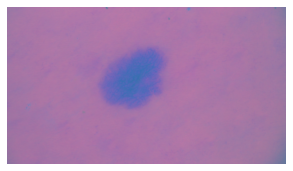

In [ ]:
before = PILDicom.create(dcmfiles[0])
show_image(before)

The image does not look natural. Let's use pydicom's `convert_color_space` to convert the image to `RGB` and see if the image looks better. 
 

<AxesSubplot:>

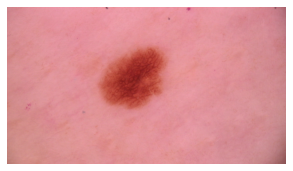

In [ ]:
after = convert_color_space(np.array(before), 'YBR_FULL_422', 'RGB'); show_image(PILImage.create(after))

Now, the image look more natural! 

We will select a smaller dataset size since the full dataset is big and takes very long to train. 

In [ ]:
df0 = df[df['target'] == 0].reset_index(drop=True)
df1 = df[df['target'] == 1].reset_index(drop=True)
len(df0), len(df1)

(32542, 584)

In [ ]:
sel = np.random.choice(df0.index, len(df1)*4)
df0 = df0.loc[sel,:]

In [ ]:
df_small = pd.concat([df0,df1]).reset_index(drop=True)

In [ ]:
df_small['target'].value_counts()

0    2336
1     584
Name: target, dtype: int64

We will make three folds using `StratifiedKFold`.

In [ ]:
N_FOLDS = 3
SEED = 101
BS=32
df_small['fold'] = -1

strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
for i, (_, test_index) in enumerate(strat_kfold.split(df_small.image_name.values, df_small['target'].values)):
    df_small.iloc[test_index, -1] = i
    
df_small['fold'] = df_small['fold'].astype('int')

# Tabular Dataloader

Here, we will make use of `TabularPandas` to build a general tabular dataloader.  

In [ ]:
fold = 0
splitter = [L(list(df_small.loc[df_small.fold!=fold].index)), L(list(df_small.loc[df_small.fold==fold].index))]
procs = [Categorify, FillMissing, Normalize]
cat_names  = ['sex', 'anatom_site_general_challenge']
cont_names = ['age_approx']
to = TabularPandas(df_small, procs, 
                   cat_names, cont_names,
                   y_names='target', y_block=CategoryBlock(),
                   splits=splitter)

In [ ]:
tab_dl = to.dataloaders(bs=BS)

In [ ]:
tab_dl.show_batch()

,sex,anatom_site_general_challenge,age_approx_na,age_approx,target
0,male,torso,False,55.000000,1
1,male,torso,False,40.000000,0
2,male,torso,False,65.000000,0
3,female,lower extremity,False,70.000000,0
4,male,torso,False,30.000000,0
5,male,torso,False,40.000000,0
6,female,lower extremity,False,15.000001,0
7,male,lower extremity,False,60.000000,1
8,female,torso,False,35.000000,0
9,female,torso,False,30.000000,0


# Image Dataloader

Next, we will build the vision dataloader. First, we will define `AlbumentationTransform` that allows fastai's `DataBlock` to work with albumentation library. 

In [ ]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img:PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']

        return PILImage.create(aug_img)

`convert_tfm` is a custom transform to convert the `YBR_FULL_422` format into `RGB`. 

In [ ]:
def convert_tfm(img:PILDicom): 
    np_img = np.array(img)
    converted_img = convert_color_space(np_img, 'YBR_FULL_422', 'RGB')
    return PILImage.create(converted_img)

In [ ]:
sz = 256

def get_train_aug(sz): return albumentations.Compose(
    [
        albumentations.Transpose(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightness(limit=0.2, p=0.75),
        albumentations.RandomContrast(limit=0.2, p=0.75),
        
        albumentations.OneOf([
            albumentations.MotionBlur(blur_limit=5),
            albumentations.MedianBlur(blur_limit=5),
            albumentations.GaussianBlur(blur_limit=5),
            albumentations.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        albumentations.OneOf([
            albumentations.OpticalDistortion(distort_limit=1.0),
            albumentations.GridDistortion(num_steps=5, distort_limit=1.),
            albumentations.ElasticTransform(alpha=3),
        ], p=0.7),

        albumentations.CLAHE(clip_limit=4.0, p=0.7),
        albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        albumentations.Resize(sz, sz),
        albumentations.Cutout(max_h_size=int(sz * 0.375), max_w_size=int(sz * 0.375), num_holes=1, p=0.7),
    ])

def get_valid_aug(sz): return  albumentations.Compose(
    [
        albumentations.Resize(sz, sz),
    ])

In [ ]:
item_tfms = [Resize(sz*2), Transform(convert_tfm), AlbumentationsTransform(get_train_aug(sz), get_valid_aug(sz))]
#item_tfms = [Resize(128)]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2611: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [ ]:
blocks = (ImageBlock(cls=PILDicom), CategoryBlock(vocab=[0,1]))
get_x = ColReader('image_name', pref=path_img, suff='.dcm')
melanoma = DataBlock(blocks=blocks,
                   get_x=get_x,
                   splitter=IndexSplitter(df_small.loc[df_small.fold==fold].index),
                   item_tfms=item_tfms,
                   get_y=ColReader('target'),
                   batch_tfms=batch_tfms)

In [ ]:
vis_dl = melanoma.dataloaders(df_small, bs=BS)

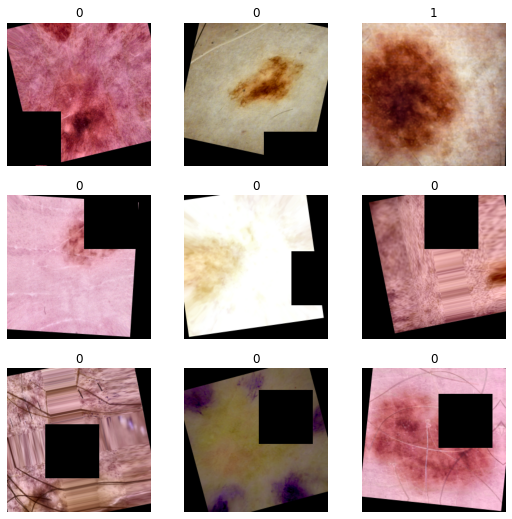

In [ ]:
vis_dl.show_batch()

Let's make sure the augmentation are working properly. `vis_dl.train` should show augmentations while `vis_dl.valid` should only `Resize`. As we can see below, the augmentations are working properly. 

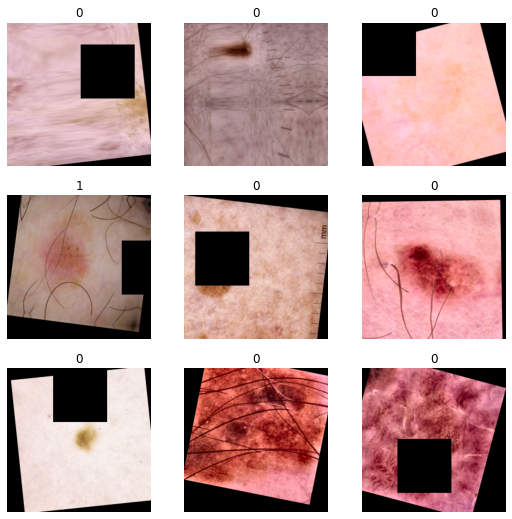

In [ ]:
vis_dl.train.show_batch()

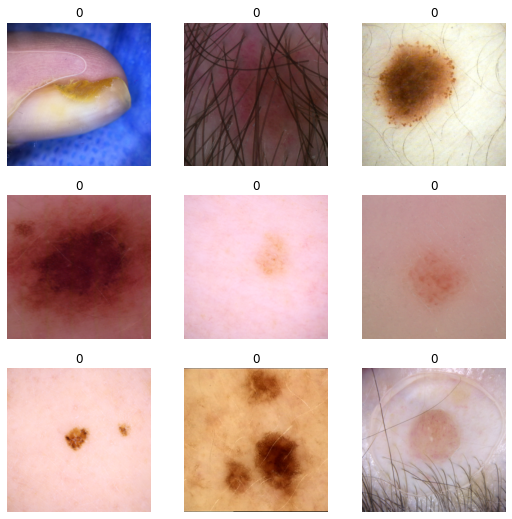

In [ ]:
vis_dl.valid.show_batch()

# MixedDL


For this part, we will make heavy use of this [notebook](https://www.kaggle.com/muellerzr/fastai2-tabular-vision-starter-kernel) by Zach. Discussion on `MixedDL` can be found [here](https://forums.fast.ai/t/combining-tabular-images-in-fastai2-and-should-work-with-almost-any-other-type/73197/13). 

Now, we will make `MixedDL` to load both `tab_dl` and `vis_dl` together. The main idea is to override the shuffle function in `tab_dl` and `vis_dl` with a common shuffle function so both the dataloaders will shuffle to contain the same data.  

In [ ]:
class MixedDL():
    def __init__(self, *dls, device='cuda:0'):
        "Accepts any number of `DataLoaders` and a device"
        self.device = device
        for dl in dls: dl.shuffle_fn = self.shuffle_fn
        self.dls = dls
        self.count = 0
        self.fake_l = _FakeLoader(self, False, 0, 0, 0)
        self._get_idxs()
        self.n_inp = 1
        
    def __len__(self): return len(self.dls[0])
    
    def _get_vals(self, x):
        "Checks for duplicates in batches"
        idxs, new_x = [], []
        for i, o in enumerate(x): x[i] = o.cpu().numpy().flatten()
        for idx, o in enumerate(x):
            if not _arrayisin(o, new_x):
                idxs.append(idx)
                new_x.append(o)
        return idxs
    
    def _get_idxs(self):
        "Get `x` and `y` indicies for batches of data"
        dl_dict = dict(zip(range(0,len(self.dls)), [dl.n_inp for dl in self.dls]))
        inps = L([])
        outs = L([])
        for key, n_inp in dl_dict.items():
            b = next(iter(self.dls[key]))
            inps += L(b[:n_inp])
            outs += L(b[n_inp:])
        self.x_idxs = self._get_vals(inps)
        self.y_idxs = self._get_vals(outs)
    
    def __iter__(self):
        z = zip(*[_loaders[i.fake_l.num_workers==0](i.fake_l) for i in self.dls])
        for b in z:   
            inps = []
            outs = []
            if self.device is not None: 
                b = to_device(b, self.device)
            for batch, dl in zip(b, self.dls):
                batch = dl.after_batch(batch)
                inps += batch[:dl.n_inp]
                outs += batch[dl.n_inp:]
            inps = L(inps)[self.x_idxs]
            outs = L(outs)[self.y_idxs]
            yield (inps, outs[0])
                
    def one_batch(self):
        "Grab one batch of data"
        with self.fake_l.no_multiproc(): res = first(self)
        if hasattr(self, 'it'): delattr(self, 'it')
        return res
    
    def shuffle_fn(self, idxs):
        "Shuffle the internal `DataLoaders`"
        if self.count == 0:
            self.rng = self.dls[0].rng.sample(idxs, len(idxs))
            self.count += 1
            return self.rng
        if self.count == 1:
            self.count = 0
            return self.rng

        
    def show_batch(self):
        "Show a batch of data"
        for dl in self.dls:
            dl.show_batch()
            
    def to(self, device): self.device = device
        

def _arrayisin(arr, arr_list):
    "Checks if `arr` is in `arr_list`"
    for a in arr_list:
        if np.array_equal(arr, a):
            return True
    return False

In [ ]:
mixed_train = MixedDL(tab_dl[0], vis_dl[0])
mixed_valid = MixedDL(tab_dl[1], vis_dl[1])
dls = DataLoaders(mixed_train, mixed_valid)

Let's check if `MixedDL` is working fine.  

,sex,anatom_site_general_challenge,age_approx_na,age_approx,target
0,male,torso,False,75.000001,0
1,male,torso,False,70.000000,1
2,female,upper extremity,False,60.000000,1
3,female,torso,False,75.000001,1
4,female,head/neck,False,40.000000,0
5,female,upper extremity,False,45.000000,0
6,female,torso,False,60.000000,0
7,male,lower extremity,False,45.000000,0
8,male,torso,False,55.000000,0
9,male,torso,False,50.000000,1


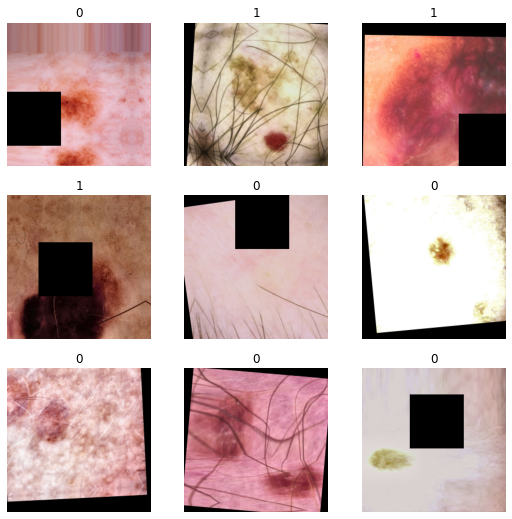

In [ ]:
dls.show_batch()

In [ ]:
dls.to('cuda')
batch = dls.one_batch()

In [ ]:
# tabular data - cat
batch[0][0]

tensor([[2, 5, 1],
        [2, 5, 1],
        [1, 6, 1],
        [1, 5, 1],
        [1, 1, 1],
        [1, 6, 1],
        [1, 5, 1],
        [2, 2, 1],
        [2, 5, 1],
        [2, 5, 1],
        [1, 5, 1],
        [2, 6, 1],
        [1, 5, 1],
        [2, 5, 1],
        [2, 2, 1],
        [1, 2, 1],
        [2, 6, 1],
        [2, 5, 1],
        [1, 5, 1],
        [2, 5, 1],
        [2, 5, 1],
        [1, 5, 1],
        [2, 4, 1],
        [2, 2, 1],
        [2, 6, 1],
        [2, 5, 1],
        [1, 5, 1],
        [1, 2, 1],
        [1, 3, 1],
        [2, 6, 1],
        [2, 5, 1],
        [1, 2, 1]], device='cuda:0')

In [ ]:
# tabular data - cont
batch[0][1]

tensor([[ 1.6585],
        [ 1.3254],
        [ 0.6592],
        [ 1.6585],
        [-0.6732],
        [-0.3401],
        [ 0.6592],
        [-0.3401],
        [ 0.3261],
        [-0.0070],
        [-0.0070],
        [-0.0070],
        [ 0.6592],
        [ 1.3254],
        [-0.6732],
        [-1.6725],
        [-0.3401],
        [ 0.6592],
        [-0.3401],
        [ 0.9923],
        [ 0.9923],
        [ 0.9923],
        [-0.0070],
        [ 1.9916],
        [ 1.3254],
        [-0.6732],
        [-0.0070],
        [-0.6732],
        [-0.6732],
        [-0.0070],
        [-1.0063],
        [-0.0070]], device='cuda:0')

In [ ]:
# image data 
batch[0][2]

TensorImage([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.80

In [ ]:
#target
batch[1]

tensor([[0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0]], device='cuda:0', dtype=torch.int8)

# Building the model

Let's build fuction to build `Tabular Model` and `Vision Model`. 

In [ ]:
def get_tabular_model(to, cont_names, out_sz=100, layers=[100,250]):
    return TabularModel(emb_szs = get_emb_sz(to),
                        n_cont = len(cont_names),
                        out_sz = out_sz,
                        layers = layers)

In [ ]:
def get_timm_vis_model(arch:str, out_sz=100, pretrained=True, cut=None):
    model = create_model(arch, pretrained=pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    model =  nn.Sequential(*list(model.children())[:cut])
    
    return model

`MelModel` combines both the model to output 1 or 0.

In [ ]:
class MelModel(Module):
    def __init__(self, to, cont_names, out_sz, arch, *args, **kwargs):
        self.tab_model = get_tabular_model(to, cont_names, out_sz=100)
        self.vis_model = get_timm_vis_model(arch, out_sz)
        self.vis_head  = create_head(num_features_model(self.vis_model), out_sz)
        self.final_head = nn.Sequential(
                            nn.BatchNorm1d(200),
                            nn.Dropout(0.25),
                            nn.Linear(200, 100, bias=False),
                            nn.ReLU(inplace=True),
                            nn.BatchNorm1d(100),
                            nn.Dropout(0.5),
                            nn.Linear(100, 2)
                                )        
    def forward(self, x):
        tab = self.tab_model(x[0], x[1])
        vis = self.vis_head(self.vis_model(x[2]))
        return self.final_head(torch.cat([tab, vis], dim=1))

The `model_splitter` fuction splits the model into layer groups for fine_tuning. 

In [ ]:
def model_splitter(m): return L(m.vis_model, nn.Sequential(m.tab_model, m.vis_head, m.final_head)).map(params)

In [ ]:
model = MelModel(to, cont_names, out_sz=100, arch='seresnext50_32x4d')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth" to /root/.cache/torch/hub/checkpoints/seresnext50_32x4d_racm-a304a460.pth


# Training

In [ ]:
def rocauc_metric(preds, targs, labels=range(2)):
    # One-hot encode targets
    targs = np.eye(2)[targs].reshape(targs.shape[0], -1)
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

In [ ]:
learn = Learner(dls, model, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                metrics=[AccumMetric(rocauc_metric, flatten=False), accuracy],
                splitter=model_splitter).to_fp16()

In [ ]:
learn.freeze()
learn.summary()

MelModel (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 3              
Embedding                                 9          True      
____________________________________________________________________________
                     32 x 5              
Embedding                                 35         True      
____________________________________________________________________________
                     32 x 3              
Embedding                                 9          True      
Dropout                                                        
BatchNorm1d                               2          True      
BatchNorm1d                               24         True      
____________________________________________________________________________
                     32 x 100            
Linear                                    1200       True      
ReLU                                                          

In [ ]:
learn.fine_tune(2, 1e-2)

epoch,train_loss,valid_loss,rocauc_metric,accuracy,time
0,0.669237,0.487517,0.683491,0.821355,1:12:36


epoch,train_loss,valid_loss,rocauc_metric,accuracy,time
0,0.532894,0.510520,0.650158,0.812115,1:12:41
1,0.481598,0.482020,0.721327,0.822382,1:12:15
